This notebook is inspired by the Andrew Ng's amazing Coursera course on Deep learning. The dataset we will be using the train the model on is the MNIST dataset which one of the default datasets in PyTorch.

In [1]:
import numpy as np 
import torch 
import torch.nn as nn 
import torchvision 
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt 
import matplotlib as mpl

%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [2]:
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
#Import MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

val_dataset = torchvision.datasets.MNIST(root='data/',
                                           train=False,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)
input_tensor, label = train_dataset[0]
print('MNIST dataset with {} train data and {} test data'.format(len(train_dataset), len(val_dataset)))
print('Type of data in dataset: {} AND {}'.format(type(input_tensor), type(label)))
print('Input tensor image dimensions: {}'.format(input_tensor.shape))

MNIST dataset with 60000 train data and 10000 test data
Type of data in dataset: <class 'torch.Tensor'> AND <class 'int'>
Input tensor image dimensions: torch.Size([1, 28, 28])


In [4]:
#Model hyper-parameters for the fully connected Neural network 
input_size = 784 # Image input for the digits - 28 x 28 x 1 (W-H-C) -- flattened in the end before being fed in the NN 
num_hidden_layers = 1
hidden_layer_size = 50
num_classes = 10 
num_epochs = 50
batch_size = 64 
learning_rate = 10e-4

torch.Size([64, 1, 28, 28]) torch.Size([64])


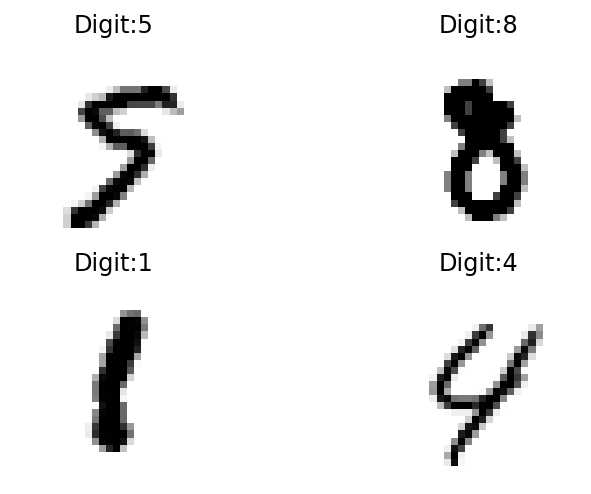

In [5]:
#Convert dataset to a dataloader class for ease of doing batching and SGD operations 
from torch.utils.data import Dataset, DataLoader
train_loader = DataLoader(dataset = train_dataset,
                          batch_size = batch_size,
                          shuffle=True,
                          num_workers = 2)

test_loader = DataLoader(dataset = val_dataset,
                        batch_size = batch_size, 
                        num_workers = 2)

#Take a look at one batch 
examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

#Plotting first 4 digits in the dataset: 
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(samples[i][0], cmap=mpl.cm.binary, interpolation="nearest")
    plt.title('Digit:{}'.format(labels[i]))
    plt.axis("off");

Above, we have defined a batch-size of 100 for the training dataset with the samples as seen here to be of size = `100 x 1 x 28 x 28`

In [6]:
#Define a model 
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_layer_size, num_classes):
        super(NeuralNet, self).__init__()
        self.L1 = nn.Linear(in_features = input_size, out_features = hidden_layer_size)
        self.relu = nn.ReLU()
        self.num_hidden_layers = num_hidden_layers
        
        if (self.num_hidden_layers-1) > 1:
            self.L_hidden = nn.ModuleList( [nn.Linear(in_features = hidden_layer_size, out_features = hidden_layer_size) for _ in range(num_hidden_layers-1)] )
            self.relu_hidden = nn.ModuleList( [nn.ReLU() for _ in range(num_hidden_layers-1)] )
        else:
            self.L2 = nn.Linear(in_features = hidden_layer_size, out_features = hidden_layer_size)
            
        self.L_out = nn.Linear(in_features = hidden_layer_size, out_features = num_classes)
    
    def forward(self, x):
        out = self.relu(self.L1(x))
        
        if (self.num_hidden_layers-1) > 1:
            for L_hidden, relu_hidden in zip(self.L_hidden, self.relu_hidden):
                out = relu_hidden(L_hidden(out))
        else:
            out = self.relu(self.L2(out))
        out = self.L_out(out) #No softmax or cross-entropy activation just the output from linear transformation
        return out

In [7]:
model = NeuralNet(input_size=input_size, 
                  num_hidden_layers=num_hidden_layers, 
                  hidden_layer_size=hidden_layer_size, 
                  num_classes=num_classes)

In [8]:
model

NeuralNet(
  (L1): Linear(in_features=784, out_features=50, bias=True)
  (relu): ReLU()
  (L2): Linear(in_features=50, out_features=50, bias=True)
  (L_out): Linear(in_features=50, out_features=10, bias=True)
)

```CrossEntropyLoss``` in Pytorch implementes Softmax activation and NLLLoss in one class.

In [9]:
#Loss and optimizer 
criterion = nn.CrossEntropyLoss() #This is implement softmax activation for us so it is not implemented in the model 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Training loop 
total_batches = len(train_loader)
losses = []
epochs = []
for epoch in range(num_epochs):
    for i, (image_tensors, labels) in enumerate(train_loader):
        running_loss = 0
        batch_count = 0
        
        #image tensor = 100, 1, 28, 28 --> 100, 784 input needed 
        image_input_to_NN = image_tensors.view(-1,28*28).to(device)
        labels = labels.to(device)
        
        #Forward pass 
        outputs = model(image_input_to_NN)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        batch_count += 1
        
        #Backward 
        optimizer.zero_grad() #Detach and flush the gradients 
        loss.backward() #Backward gradients evaluation 
        optimizer.step() #To update the weights/parameters in the NN 
        
        if (epoch) % 10 == 0 and (i+1) % 500 == 0: 
            print(f'epoch {epoch+1} / {num_epochs}, batch {i+1}/{total_batches}, loss = {loss.item():.4f}')
    
    loss_per_epoch = running_loss / batch_count
    epochs.append(epoch)
    losses.append(loss_per_epoch)

epoch 1 / 50, batch 500/938, loss = 0.2568
epoch 11 / 50, batch 500/938, loss = 0.0431
epoch 21 / 50, batch 500/938, loss = 0.0141
epoch 31 / 50, batch 500/938, loss = 0.0032
epoch 41 / 50, batch 500/938, loss = 0.0518


Text(0, 0.5, 'Loss Value')

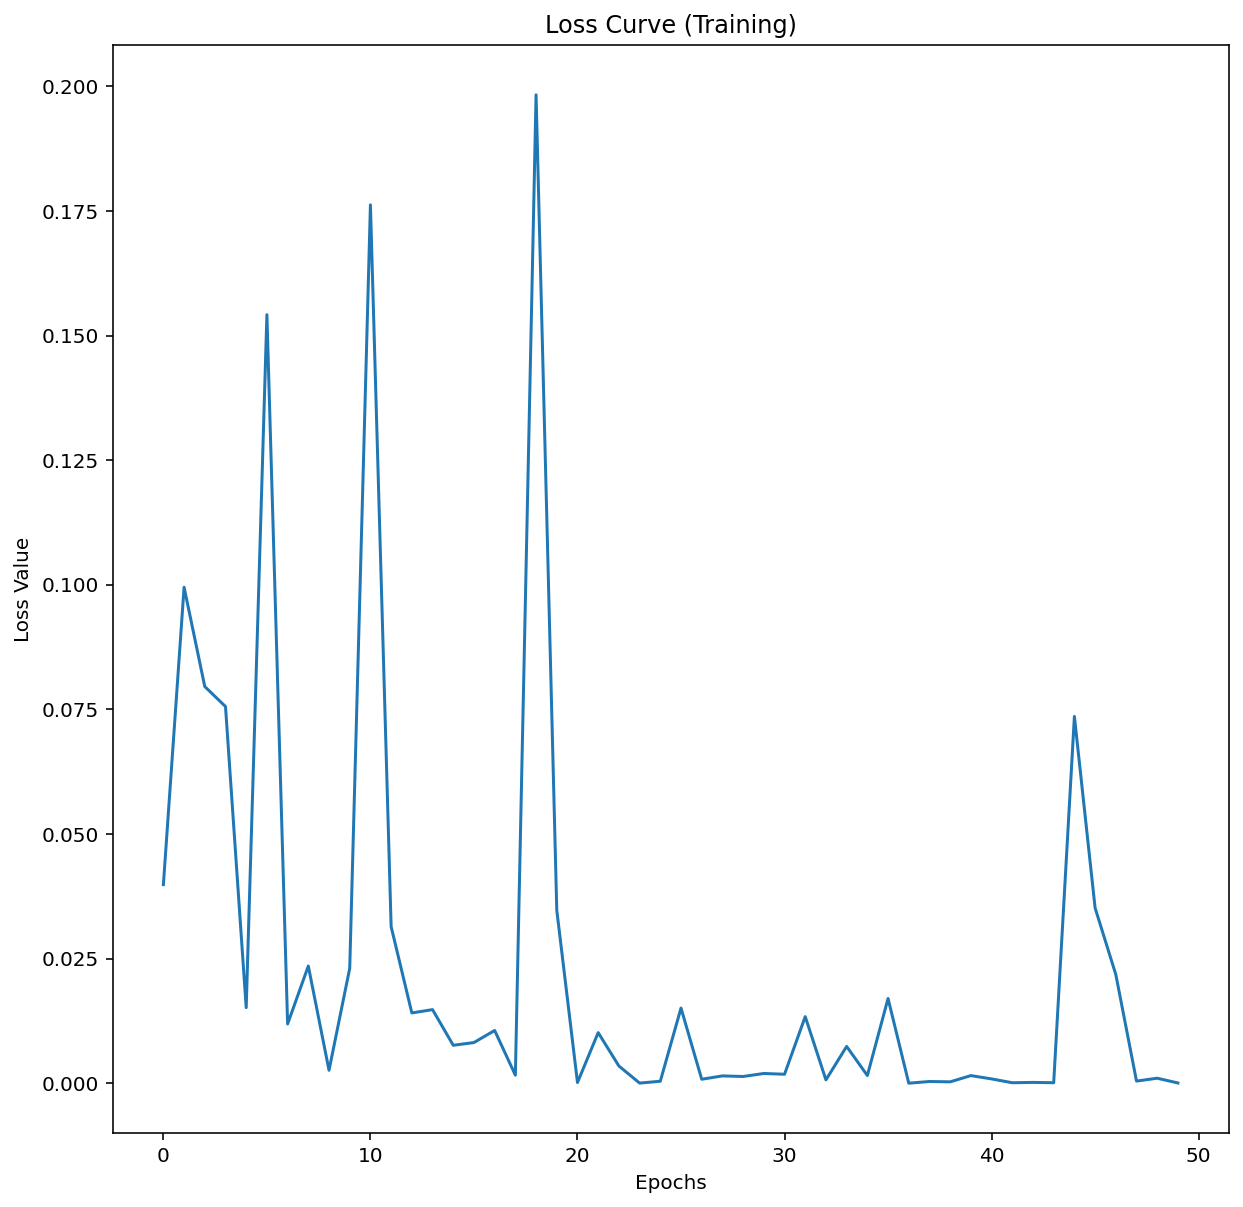

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(epochs, losses)
plt.title('Loss Curve (Training)')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss Value')

In [11]:
#Test 
with torch.no_grad():
    n_correct = 0 
    n_samples = 0 
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item() #For each correction prediction we add the correct samples 
    acc = 100 * n_correct / n_samples
    print(f'Accuracy = {acc:.2f}%')

Accuracy = 97.54%
